# Treinamento do Modelo de Detecção de Phishing

Este notebook implementa o pipeline completo de treinamento e avaliação de um modelo de Machine Learning para detecção de URLs de phishing.

## Etapas:
1. Importação das bibliotecas
2. Carregamento dos dados
3. Preparação das features
4. Divisão treino/teste
5. Treinamento do modelo (Naive Bayes)
6. Avaliação e métricas
7. Visualização da matriz de confusão

## 1. Importação das Bibliotecas

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

## 2. Definição das Features

Definimos as features que serão utilizadas pelo modelo para classificação:

In [2]:
FEATURES = [
    'url_length', 'domain_length',
    'dot_count', 'hyphen_count', 'underscore_count', 'slash_count',
    'question_count', 'equal_count', 'at_count',
    'digits_count', 'letters_count',
    'has_ip', 'has_https',
    'digit_letter_ratio', 'suspicious_words', 'is_shortened'
]

## 3. Função para Carregamento dos Dados

In [3]:
def get_data(filepath, features):
    """Carrega e prepara os dados do CSV.

    Args:
        filepath: Caminho para o arquivo CSV
        features: Lista de features a serem extraídas

    Returns:
        X: DataFrame com as features
        y: Series com os labels (is_phishing)
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Arquivo não encontrado: {filepath}")
        return None, None

    for col in features:
        if col in df.columns:
            print(f"Processando coluna: {col}")
            df[col] = df[col].replace([np.inf, -np.inf], 0)
            df[col] = df[col].fillna(0)
            df[col] = df[col].astype(int)
        else:
            print(f"Coluna não encontrada, criando: {col}")
            df[col] = 0

    return df[features], df['is_phishing']

## 4. Carregamento dos Dados

In [4]:
DATA_PATH = 'data/phishing_site_urls_cleaned.csv'

if not os.path.exists(DATA_PATH):
    print("⚠️ Dados não encontrados. Execute 'cleaning.ipynb' primeiro para gerar o dataset.")
else:
    X, y = get_data(DATA_PATH, FEATURES)

    if X is not None and not X.empty:
        print("\nDados carregados com sucesso!")
        print(f"Shape do dataset: {X.shape}")
        print(f"Features utilizadas: {list(X.columns)}")

Processando coluna: url_length
Processando coluna: domain_length
Processando coluna: dot_count
Processando coluna: hyphen_count
Processando coluna: underscore_count
Processando coluna: slash_count
Processando coluna: question_count
Processando coluna: equal_count
Processando coluna: at_count
Processando coluna: digits_count
Processando coluna: letters_count
Processando coluna: has_ip
Coluna não encontrada, criando: has_https
Processando coluna: digit_letter_ratio
Processando coluna: suspicious_words
Processando coluna: is_shortened

Dados carregados com sucesso!
Shape do dataset: (507195, 16)
Features utilizadas: ['url_length', 'domain_length', 'dot_count', 'hyphen_count', 'underscore_count', 'slash_count', 'question_count', 'equal_count', 'at_count', 'digits_count', 'letters_count', 'has_ip', 'has_https', 'digit_letter_ratio', 'suspicious_words', 'is_shortened']


## 5. Exploração dos Dados

In [5]:
# Visualização das primeiras linhas
X.head()

,url_length,domain_length,dot_count,hyphen_count,underscore_count,slash_count,question_count,equal_count,at_count,digits_count,letters_count,has_ip,has_https,digit_letter_ratio,suspicious_words,is_shortened
0,225,15,6,4,4,10,1,4,0,58,135,0,0,0,4,0
1,81,9,5,2,1,4,0,2,0,1,65,0,0,0,2,0
2,177,4,7,1,0,11,0,0,0,47,111,0,0,0,4,0
3,60,10,6,0,0,2,0,0,0,0,52,0,0,0,1,0
4,116,6,1,1,0,10,1,0,0,21,82,0,0,0,0,0


In [6]:
# Estatísticas descritivas
X.describe()

,url_length,domain_length,dot_count,hyphen_count,underscore_count,slash_count,question_count,equal_count,at_count,digits_count,letters_count,has_ip,has_https,digit_letter_ratio,suspicious_words,is_shortened
count,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.000000,507195.0,507195.000000,507195.000000,507195.000000
mean,51.467085,9.262536,2.058311,1.194044,0.408143,2.496596,0.164254,0.279238,0.003847,4.744964,39.653358,0.007954,0.0,0.013174,0.290005,0.000881
std,42.846374,16.846760,1.523663,2.494430,1.288795,1.600843,0.469652,0.936654,0.068264,11.301573,30.234555,0.088827,0.0,0.179192,0.700987,0.029674
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,30.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,41.000000,5.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,33.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,60.000000,12.000000,2.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,6.000000,47.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,2307.000000,2263.000000,37.000000,42.000000,200.000000,35.000000,166.000000,34.000000,10.000000,545.000000,2141.000000,1.000000,0.0,16.000000,11.000000,1.000000


In [7]:
# Distribuição das classes
print("Distribuição das classes:")
print(y.value_counts())
print(f"\nProporção: {y.value_counts(normalize=True).round(4) * 100}%")

Distribuição das classes:
is_phishing
0    392897
1    114298
Name: count, dtype: int64

Proporção: is_phishing
0    77.46
1    22.54
Name: proportion, dtype: float64%


## 6. Divisão Treino/Teste

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

Tamanho do conjunto de treino: 355036
Tamanho do conjunto de teste: 152159


## 7. Treinamento do Modelo

Utilizamos o algoritmo **Gaussian Naive Bayes** para classificação.

In [9]:
def train_episode(model, X_train, y_train):
    """Treina o modelo usando partial_fit para aprendizado incremental.

    Args:
        model: Modelo sklearn
        X_train: Features de treino
        y_train: Labels de treino

    Returns:
        model: Modelo treinado
    """
    classes = np.unique(y_train)
    model.partial_fit(X_train, y_train, classes=classes)
    return model

In [10]:
# Instanciando e treinando o modelo
gnb = GaussianNB()
model = train_episode(gnb, X_train, y_train)

print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


## 8. Avaliação do Modelo

In [11]:
def evaluate(model, X_test, y_test):
    """Avalia o modelo e retorna métricas.

    Args:
        model: Modelo treinado
        X_test: Features de teste
        y_test: Labels de teste

    Returns:
        acc: Acurácia
        cm: Matriz de confusão
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nAcurácia: {acc:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Legítimo', 'Phishing']))

    return acc, confusion_matrix(y_test, y_pred)

In [12]:
# Avaliando o modelo
accuracy, cm = evaluate(model, X_test, y_test)


Acurácia: 0.8303

Relatório de Classificação:
              precision    recall  f1-score   support

    Legítimo       0.83      0.98      0.90    117980
    Phishing       0.83      0.31      0.45     34179

    accuracy                           0.83    152159
   macro avg       0.83      0.64      0.67    152159
weighted avg       0.83      0.83      0.80    152159



## 9. Visualização da Matriz de Confusão

In [13]:
def plot_confusion_matrix(cm, save_path=None):
    """Plota a matriz de confusão.

    Args:
        cm: Matriz de confusão
        save_path: Caminho para salvar a imagem (opcional)
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Legítimo', 'Phishing'],
        yticklabels=['Legítimo', 'Phishing']
    )
    plt.title('Matriz de Confusão')
    plt.ylabel('Real')
    plt.xlabel('Previsto')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Gráfico salvo em: {save_path}")

    plt.show()


💾 Gráfico salvo em: reports/confusion_matrix.png


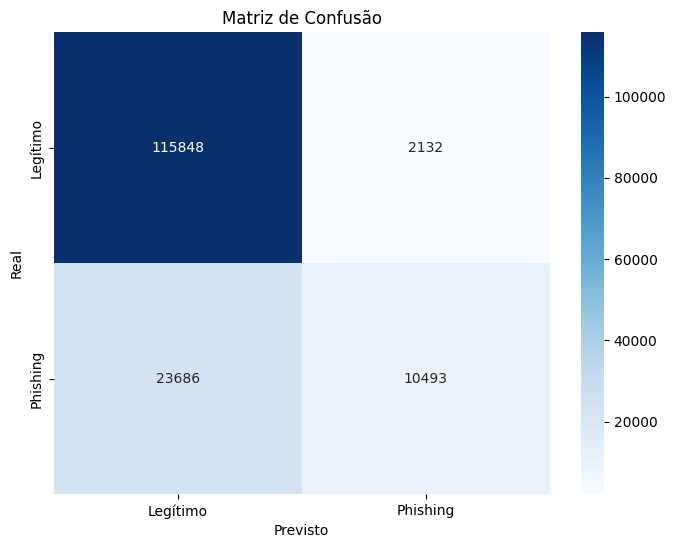

In [14]:
# Plotando e salvando a matriz de confusão
plot_confusion_matrix(cm, save_path='reports/confusion_matrix.png')

## 10. Resumo dos Resultados

In [16]:
print("=" * 50)
print("RESUMO DO TREINAMENTO")
print("=" * 50)
print("\n- Modelo: Gaussian Naive Bayes")
print(f"- Total de amostras: {len(X)}")
print(f"- Amostras de treino: {len(X_train)}")
print(f"- Amostras de teste: {len(X_test)}")
print(f"- Número de features: {X.shape[1]}")
print(f"\n- Acurácia final: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n" + "=" * 50)

RESUMO DO TREINAMENTO

- Modelo: Gaussian Naive Bayes
- Total de amostras: 507195
- Amostras de treino: 355036
- Amostras de teste: 152159
- Número de features: 16

- Acurácia final: 0.8303 (83.03%)

